In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import json
import seaborn as sns
import pareto
import math

In [2]:
### check if in WSL (for Andrew) and if so, add font location
from platform import uname
if 'Microsoft' in uname().release:
  import matplotlib.font_manager as font_manager
  font_dirs = ['/mnt/c/Windows/Fonts/', ]
  font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
  for font_file in font_files:
    font_list = font_manager.fontManager.addfont(font_file)

## set default font type/size
rcParams['font.family'] = 'Arial'
rcParams.update({'font.size': 8})

In [3]:
results = pd.read_csv('FKC_experiment/objs_clean.csv')
# results = pd.read_csv('FKC_experiment/objs_aggHydro.csv')

results

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (183) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,scenario,num_partners,initial_recharge,tot_storage,recovery,total_partner_avg_gain,min_partner_avg_gain,total_other_avg_gain,min_other_avg_gain,total_partner_w5yr_gain,...,OTL_avg_price,OFK_avg_price,OCD_avg_price,OEX_avg_price,OXV_avg_price,OSW_avg_price,CNS_avg_price,ALT_avg_price,KRWA_avg_price,worst_price_avg_gain
0,FKC_experiment_capow_50yr_dry_0_CFWB,11,262.219172,0.837157,0.042158,4.002644,-4.808658,-43.165392,-15.092812,24.321818,...,-0.0,199.980478,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,2000.0
1,FKC_experiment_capow_50yr_median_0_CFWB,11,262.219172,0.837157,0.042158,13.736686,-7.331878,-53.097521,-18.542784,31.921009,...,-0.0,194.716693,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,2000.0
2,FKC_experiment_capow_50yr_wet_0_CFWB,11,262.219172,0.837157,0.042158,24.216171,-3.743586,-33.597786,-13.656919,44.270869,...,-0.0,143.927373,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,2000.0
3,FKC_experiment_capow_50yr_dry_0_FKC,11,0.000000,0.000000,0.000000,17.698446,-0.163329,7.693190,-2.808130,8.015359,...,-0.0,1505.207822,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,2000.0
4,FKC_experiment_capow_50yr_median_0_FKC,11,0.000000,0.000000,0.000000,30.653772,-1.746729,17.232832,-0.642217,15.196825,...,-0.0,1038.503136,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27280,FKC_experiment_capow_50yr_median_friantEqual,16,0.000000,0.000000,0.000000,37.861537,-0.379106,-1.488152,-1.122679,5.441429,...,-0.0,2000.000000,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,2000.0
27281,FKC_experiment_capow_50yr_wet_friantEqual,16,0.000000,0.000000,0.000000,36.207185,-1.010200,-3.291193,-1.077416,-6.299983,...,-0.0,698.036782,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,2000.0
27282,FKC_experiment_capow_50yr_dry_friantHistorical,16,0.000000,0.000000,0.000000,18.757115,-0.653253,-7.114486,-1.230022,16.037027,...,-0.0,927.168030,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,2000.0
27283,FKC_experiment_capow_50yr_median_friantHistorical,16,0.000000,0.000000,0.000000,37.559318,-0.510677,-1.971530,-1.270048,6.931408,...,-0.0,2000.000000,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,2000.0


In [4]:
districts = [d.split('_')[0] for d in results.columns if 'w5yr_gain' in d.split('_',1)]
share_keys = [d + '_share' for d in districts]
exp_gain_keys = [d + '_exp_gain' for d in districts]
w5yr_gain_keys = [d + '_w5yr_gain' for d in districts]
avg_price_keys = [d + '_avg_price' for d in districts]
objs_keys = ['total_partner_avg_gain', 'min_partner_avg_gain','total_other_avg_gain', 'min_other_avg_gain', 'total_partner_w5yr_gain','min_partner_w5yr_gain', 'ginicoef', 'avg_price_gain_dolAF']

In [6]:
# ## divide prices by 100
# results.avg_price_gain_dolAF /= 100
# results.worst_price_avg_gain /= 100
# results.loc[:, avg_price_keys] /= 100

In [ ]:
# ### get avg price paid for water for each district. cap at $2000.
# cap = 2000
# for d in districts:
#     results[d + '_avg_price2'] = results['avg_price_gain_dolAF'] * results[d + '_share'] * results['total_partner_avg_gain'] / results[d + '_exp_gain'] 
#     results[d + '_avg_price2'] = [cap if p < 0 or p > cap else p for p in results[d + '_avg_price']]
#     results[d + '_avg_price2'].loc[np.isnan(results[d+'_avg_price'])] = [cap if s > 0 else 0 for s in results[d + '_share'].loc[np.isnan(results[d+'_avg_price'])]]
    
# results['avg_price_gain_dolAF2'] = [cap if p < 0 or p > cap else p for p in results['avg_price_gain_dolAF']]

In [6]:
### fix district costs, method in clean_objs.py doesn't handle negative-CWG projects correctly
cap = 3000
### get avg price of water gains per year
FKC_cost = 500e6
FKC_fed_payment = 200e6
FKC_east_tule_payment = 125e6
FKC_participant_payment = FKC_cost - FKC_fed_payment - FKC_east_tule_payment
CFWB_cost = 100e6
interest_annual = 0.03
time_horizon = 50

principle = {'FKC': FKC_participant_payment, 'CFWB': CFWB_cost, 'FKC_CFWB': FKC_participant_payment + CFWB_cost}
payments_per_yr = 1
interest_rt = interest_annual / payments_per_yr
num_payments = time_horizon * payments_per_yr
annual_payment = {k: principle[k] / (((1 + interest_rt) ** num_payments - 1) / (interest_rt * (1 + interest_rt) ** num_payments)) for k in principle}
annual_payment

{'FKC': 6801461.52729321,
 'CFWB': 3886549.444167549,
 'FKC_CFWB': 10688010.97146076}

In [5]:
results['annual_payment'] = [annual_payment[p] for p in results['project']]
results['avg_price_gain_dolAF'] = results['annual_payment'] / results['total_partner_avg_gain'] / 1000
results['avg_price_gain_dolAF'].loc[np.logical_or(results['avg_price_gain_dolAF'] < 0, results['avg_price_gain_dolAF'] > cap)] = cap
for d in districts:
    results[d + '_avg_price'] = results['annual_payment'] * results[d + '_share'] / results[d + '_exp_gain'] / 1000
    results[d + '_avg_price'].loc[np.logical_or(results[d + '_avg_price'] < 0, results[d + '_avg_price'] > cap)] = cap
results['worst_price_avg_gain'] = np.max(results.loc[:,avg_price_keys], axis=1)

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [6]:
def get_colors(s, results_single, partner_order_col='exp_gain', other_order_col='exp_gain'):
    npartners = (results.loc[:,share_keys].iloc[s,:] > 0.0).sum()
    ntot = results_single.shape[0] 
    nothers = ntot - npartners
    cmax = 1
    cmin = 0.5
    cmpartner = cm.get_cmap('Blues')
    cmother = cm.get_cmap('Oranges')
    
    ### color based on rank of order_col
    l = []
    partners = 0
    others = 0
    for i in range(ntot):
        if results_single['share'].iloc[i] > 0.0:
            l.append(cmpartner(cmax - (partners/npartners) * (cmax - cmin)))
            partners += 1
        else:
#             l.append(cmother(cmin + (others/nothers) * (cmax - cmin)))
            l.append(cmother(cmax - (others/nothers) * (cmax - cmin)))
            others += 1           
    results_single['color'] = l

    ### color based on magnitude of order_col
#     range_partner = [results_single[partner_order_col].loc[results_single.partner == 1].min(), results_single[partner_order_col].loc[results_single.partner == 1].max()]
#     range_other = [results_single[other_order_col].loc[results_single.partner == 0].min(), results_single[other_order_col].loc[results_single.partner == 0].max()]
#     results_single['color'] = [cmpartner(cmin + (cmax-cmin)* (v - range_partner[0]) / (range_partner[1] - range_partner[0]) ) for v in results_single[partner_order_col]]
#     results_single['color'].loc[results_single.partner == 0] = [cmother(cmin + (cmax-cmin)* (v - range_other[0]) / (range_other[1] - range_other[0]) ) for v in results_single[other_order_col].loc[results_single.partner == 0]]
    
    return results_single

In [7]:
### get single set of results, reorder districts by shares
def get_results_single(s, districts_order=[], districts_anon=[], first_time=False):
    r = results.iloc[s, :]
    district_labels = districts if first_time else districts_anon
    results_single = pd.DataFrame({'district_label': district_labels, 
                                   'district': districts,
                                   'share': list(results.loc[:,share_keys].iloc[s, :]),
                                   'exp_gain': list(results.loc[:,exp_gain_keys].iloc[s, :]),
                                   'w5yr_gain': list(results.loc[:,w5yr_gain_keys].iloc[s, :]),
                                   'avg_price': list(results.loc[:,avg_price_keys].iloc[s, :]),
                                   'partner': [1 if v > 0.0 else 0 for v in results.loc[:,share_keys].iloc[s,:]]})

    results_single.index = results_single.district
    if len(districts_order) > 0:
        results_single = results_single.reindex(districts_order)
    else:
        results_single.sort_values(['share', 'exp_gain'], inplace=True, ascending=False)
#     if not first_time:
        # remove all-zero rows
#         results_single = results_single.loc[np.abs(results_single.share) + np.abs(results_single.exp_gain) + np.abs(results_single.w5yr_gain) > 1e-10, :]

    results_single = get_colors(s, results_single, 'share', 'exp_gain')
    
    return results_single

In [93]:
# ### anonymize districts based on friant benefits
# contract_abbrev = {'tableA': 'SD', 'friant1': 'F1', 'friant2': 'F2', 'kern': 'KN', 'tule': 'TL', 'kaweah': 'KW', 'kings': 'KG',
#                    'exchange': 'EX', 'cvpdelta': 'CD', 'cvc': 'XV'}
# contracts = {}
# contract_count = {}

# for d in districts:
#     params = json.load(open('calfews_src/districts/' + d + '_properties.json'))
#     largest_contract = 'None'
#     fraction = 0.0
#     for c in params['contract_list']:
#         try:
#             f = params['project_contract'][c]
#         except:
#             try:
#                 f = params['rights'][c]['capacity']
#             except:
#                 f = -1
#         if f > fraction:
#             fraction = f
#             largest_contract = c
#     if largest_contract in contract_count:
#         contract_count[largest_contract] += 1
#     else:
#         contract_count[largest_contract] = 1
#     contracts[d] = contract_abbrev[largest_contract] + '-' + str(contract_count[largest_contract])

# districts_anon = [contracts[d] for d in districts]       

In [8]:
### anonymize based on friant participation, & ordered based on benefits in status quo ownership, medium hydro, FKC
districts_order = get_results_single(-2,[],[],True).district
districts_color = get_results_single(-2,[],[],True).color
anon_dict = {districts_order[i]: 'F-' + str(i + 1) if i < 16 else 'O-' + str(i - 15) for i in range(0, len(districts_order))}
districts_anon = [anon_dict[d] for d in districts]
# districts_anon

In [ ]:
# ### circular plot (following https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python)

# def make_polar_plot(s, quadrants_vis):

#     results_single = get_results_single(s)
#     results_single.reset_index(inplace=True, drop=True)
#     results_single = get_colors(s, results_single)

#     plt.figure(figsize=(12,12))
#     N = results_single.shape[0]
#     npartners = sum(results.iloc[s, :].loc[share_keys] > 0)

#     ax = plt.subplot(111, polar=True)

#     def plot_rlabels(labels, angle, radii, is_title):
#         for i in range(len(labels)):
#             if is_title[i]:
#                 ax.annotate(labels[i], (angle - np.pi/4, radii[i]), ha='center', va='center', ma='center',
#                             rotation= ((int(angle*180/np.pi) - 90) % 180) - 45, annotation_clip=False, weight='bold', fontsize=14)
#             else:
#                 ax.annotate(labels[i], (angle - np.pi/4, radii[i]), ha='center', va='center', ma='center',
#                             rotation= ((int(angle*180/np.pi) - 90) % 180) - 45, annotation_clip=False, fontsize=12)

#     def plot_districtlabels(labels, radii, theta, colors):
#         for i in range(N):
#             t = (theta[i] * 180 / np.pi + 360) % 360
#             shift = -np.pi/N/8 if t<=90 or t>270 else np.pi/N/8
#             ax.annotate(labels[i], (theta[i] + shift, radii[i]),ha='center', va='center', ma='center', color=colors[i],
#                        rotation= ((theta[i]*180/np.pi - 90) % 180) - 90, annotation_clip=False, fontsize=8)


#     def plot_averages(key, theta, scaler):
#         partner_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
#                         'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
#                         'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
#                         'share': 1.0 / npartners}
#         other_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
#                       'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
#                       'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
#                       'share': 1.0 / npartners} 
#         t = list(theta[:npartners])
#         t = [t[0] + np.pi/N/4] + t + [t[-1] - np.pi/N/4]
#         ax.plot(t, [partner_dict[key] / scaler for _ in t], c=cm.get_cmap('Blues')(0.95))
#         t = list(theta[npartners:])
#         t = [t[0] + np.pi/N/4] + t + [t[-1] - np.pi/N/4]
#         if key in ['exp_gain', 'w5yr_gain']:
#             ax.plot(theta[npartners:], [other_dict[key] / scaler for _ in theta[npartners:]], c=cm.get_cmap('Reds')(0.95))
#         else:
#             ax.plot(theta[npartners:], [0 for _ in theta[npartners:]], c=cm.get_cmap('Reds')(0.95))
            


#     def plot_quadrant(key, quadrant, quadrant_vis):
#         offset_dict = {'NE': np.pi/2, 'SE': 0, 'SW': -np.pi/2, 'NW': np.pi}
#         offset = offset_dict[quadrant]
#         label_dict = {'NE': 'Ownership\nshare', 'SE': 'Avg. gains\n(kAF/yr)', 
#                       'SW': 'Drought gains\n(kAF/yr)', 'NW': 'Avg. cost\n($\AF)'}
#         label = label_dict[quadrant]
#         label_radius_dict = {'NE': 1.4, 'SE': 1.4, 'SW': 1.4, 'NW': 1.4}
#         label_radius = label_radius_dict[quadrant]

#         theta = offset - np.pi / N / 4 - np.linspace(0.0, 2 * np.pi / 4, N, endpoint=False)
#         scaler = round(np.abs(results_single[key]).max(), 2)
#         radii = results_single[key] / scaler
#         colors = results_single['color']
#         width = (2*np.pi) / N / 4
#         if quadrant_vis:
#             bars = ax.bar(theta, radii, width=width, bottom=0, alpha=1)
#             for r, c, bar in zip(radii, colors, bars):
#                 bar.set_facecolor(c)
#                 bar.set_alpha(0.8)
#             plot_rlabels((-0.5*scaler, 0, 0.5*scaler, 1*scaler, label), offset, (-0.5, 0, 0.5, 1, label_radius),
#                         (False, False, False, False, True))
#             plot_averages(key, theta, scaler)
#             plot_districtlabels(results_single.district.values, [1.2 for _ in theta], theta, results_single.color.values)
#         else:
#             bars = ax.bar(theta, radii, width=width, bottom=0, alpha=0)


#     quadrant_vis = True
#     plot_quadrant('share', 'NE', quadrant_vis)
#     if quadrants_vis < 2:
#         quadrant_vis = False
#     plot_quadrant('exp_gain', 'SE', quadrant_vis)
#     if quadrants_vis < 3:
#         quadrant_vis = False
#     plot_quadrant('w5yr_gain', 'SW', quadrant_vis)
#     if quadrants_vis < 4:
#         quadrant_vis = False
#     plot_quadrant('avg_price', 'NW', quadrant_vis)


#     ax.set_rgrids([-0.5, 0, 0.5, 1], ['', '', '', ''], 0)
#     ax.set_thetagrids([90, 0, 270, 180])
#     # ax.set_ylim([-0.8, 1])
#     a = ax.set_xticklabels(['','','',''])



In [ ]:
### aggHydro_nondom solns
# s = 204  #highest total avg
# s = 188  #highest w5yr avg
# s = 34  #lowest price
# s = 204   #good example with large num_districts & total_gain


### aggHydro solns
# s = 6331  # fkc-only, good example of decent but not-ideal policy. many partners, some w/bad outcomes, 1 non-partner w/ high benefits
# s = 2913  # 2900, 2540 very bad policies
s = -2

# make_polar_plot(s, 4)
# plt.savefig('polar'+str(s)+'.png')
# print(results.iloc[s,:15])

In [ ]:
# def make_hist_plot(ss, titles=[''], ylab_shift=-300, district_label_fontsize=9, use_reorder=True, districts_order=[], districts_anon=[], save_results=''):
#     if len(ss) > 1:
#         fig, axs = plt.subplots(4,len(ss), figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'wspace':0})
#     else:    
#         fig, axs = plt.subplots(4,1, figsize=(8,6), sharex=True, gridspec_kw={'hspace':0, 'wspace':0})
    
#     ylim = {}
    
#     for i,s in enumerate(ss):
#         if (use_reorder==False):
#             results_single = get_results_single(s, [], [], True)
#             districts_order = results_single.index
#         else:
#             results_single = get_results_single(s, districts_order, districts_anon)
        
#         if not save_results == '':
#             print('here')
#             results_single.to_csv('figures/results_' + save_results + '.csv')
            
#         N = results_single.shape[0]
#         npartners = sum(results.iloc[s, :].loc[share_keys] > 0)

#         def plot_averages(key, x, y, ax):
#             partner_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
#                             'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
#                             'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
#                             'share': 1.0 / npartners}
#             other_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
#                           'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
#                           'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
#                           'share': 1.0 / npartners} 

#             ax.plot(x[:npartners], [partner_dict[key] for _ in x[:npartners]], c=cm.get_cmap('Blues')(0.9))

#             if key in ['exp_gain', 'w5yr_gain']:
#                 ax.plot(x[npartners:], [other_dict[key] for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.9))
#             else:
#                 ax.plot(x[npartners:], [0 for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.95))

#         def plot_single_hist(key, ax, use_xlab, use_ylab, ax_sharey=None):
#             label_dict = {'share': 'Ownership\nshare', 'exp_gain': 'Avg. gains\n(kAF/yr)', 
#                           'w5yr_gain': 'Drought gains\n(kAF/yr)', 'avg_price': 'Avg. cost\n($\AF)'}
#             label = label_dict[key]
#             height = results_single[key] 
#             try:
#                 ylim[key]['max'] = max(ylim[key]['max'], max(height))
#             except:
#                 ylim[key] = {}
#                 ylim[key]['max'] = max(height)
#             try:
#                 ylim[key]['min'] = min(ylim[key]['min'], min(height))
#             except:
#                 ylim[key]['min'] = min(height)
                
#             colors = districts_color
#             bars = ax.bar(results_single['district'], height)
#             for r, c, bar in zip(height, colors, bars):
#                 bar.set_facecolor(c)
#                 bar.set_alpha(0.8)
#             plot_averages(key, results_single['district'], height, ax)
#             if use_xlab:
#                 ax.set_xticklabels(['' for _ in results_single['district']])
#             else:
#                 ax.set_xticks([])
#             if not use_ylab:
#                 ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
#             else:
#                 ax.set_ylabel(label)

#         def plot_district_labels(labels, colors, ax, label_offset, fontsize):
#             for i in range(N):
#                 ax.annotate(results_single['district_label'].iloc[i], (i, label_offset),ha='center', va='center', ma='center', 
#                             color=colors[i], rotation= 90, annotation_clip=False, fontsize=fontsize)

#         use_ylab = i==0
        
#         if len(ss) == 1:   
#             label_offset = ylab_shift
#             plot_single_hist('share', axs[0], False, use_ylab, axs[0])
#             plot_single_hist('exp_gain', axs[1], False, use_ylab, axs[1])
#             plot_single_hist('w5yr_gain', axs[2], False, use_ylab, axs[1])
#             plot_single_hist('avg_price', axs[3], True,use_ylab, axs[3])
#             plot_district_labels(results_single['district'], districts_color, axs[3], label_offset, district_label_fontsize)
#         else:
#             label_offset = ylab_shift
#             plot_single_hist('share', axs[0,i], False, use_ylab, axs[0])
#             plot_single_hist('exp_gain', axs[1,i], False, use_ylab, axs[0,0])
#             plot_single_hist('w5yr_gain', axs[2,i], False, use_ylab, axs[0,0])
#             plot_single_hist('avg_price', axs[3,i], True, use_ylab, axs[2,0])
#             plot_district_labels(results_single['district'], districts_color, axs[3,i], label_offset, district_label_fontsize)
    
#     if len(ss) > 1:
#         for i,s in enumerate(ss):
#             for row in [1,2]:
#                 ymin = min(ylim['exp_gain']['min'], ylim['w5yr_gain']['min'])
#                 ymax = max(ylim['exp_gain']['max'], ylim['w5yr_gain']['max'])
#                 delta = (ymax - ymin) * 0.05
#                 axs[row, i].set_ylim([ymin - delta, ymax + delta])
#             axs[0,i].set_ylim([ylim['share']['min'], ylim['share']['max'] * 1.05])
#             axs[3,i].set_ylim([ylim['avg_price']['min'], ylim['avg_price']['max'] * 1.05])
#             axs[0,i].set_title(titles[i])
              
#     else:
#         for row in [1,2]:
#             ymin = min(ylim['exp_gain']['min'], ylim['w5yr_gain']['min'])
#             ymax = max(ylim['exp_gain']['max'], ylim['w5yr_gain']['max'])
#             delta = (ymax - ymin) * 0.05
#             axs[row].set_ylim([ymin - delta, ymax + delta])
#         axs[0].set_ylim([ylim['share']['min'], ylim['share']['max'] * 1.05])

#         axs[0].set_title(titles[0])
    
#     fig.tight_layout()

In [ ]:
# s = [-2]#, -1, -3]

# print(results.iloc[s[0],:20])
# print(results.iloc[s[0],]['avg_price_gain_dolAF'])
# print('min price: ', min([v for v in results.iloc[s[0]].loc[avg_price_keys].values if v>0]))
# print('max price: ', max([v for v in results.iloc[s[0]].loc[avg_price_keys].values if v>0]))

# make_hist_plot(s, [''], -330, 9, True, districts_order, districts_anon, 'default')
# plt.savefig('figures/' + 'hist_statusquo_med' + '.png', bbox_layout='tight', dpi=500)

In [ ]:
# s = [-5,-2]
# titles = ['Equal shares','Weighted shares']
# make_hist_plot(s, titles, -300, 6, True, districts_order, districts_anon, '')
# plt.savefig('figures/' + 'hist_statusquo_hydro' + '.png', bbox_layout='tight', dpi=500)

In [ ]:
# s = [-1, -2, -3]
# titles = ['Wet time series','Average time series','Dry time series']
# make_hist_plot(s, titles, -300, 6, True, districts_order, districts_anon, '')
# plt.savefig('figures/' + 'hist_statusquo_hydro' + '.png', bbox_layout='tight', dpi=500)

### new simpler hist w/ aggregated non-partners

In [11]:
def make_hist_plot2(ss, titles=[''], ylab_shift=-300, district_label_fontsize=9, water_yticks=[], ylims = [], districts_order=[], districts_anon=[], results_single=[]):
    fig, axs = plt.subplots(4,1, figsize=(3,5), sharex=True, gridspec_kw={'hspace':0.1, 'wspace':0})
    
    if ylims == []:
        ylim = {}
    
    N = results_single.shape[0]
    npartners = sum(results_single.partner)

    def plot_averages(key, x, y, ax):
        partner_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
                        'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
                        'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] > 0.0]),
                        'share': 1.0 / npartners}
        other_dict = {'avg_price': min(results.iloc[s,:].loc['avg_price_gain_dolAF'], 2000), 
                      'exp_gain': np.mean([results_single.iloc[i].loc['exp_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
                      'w5yr_gain': np.mean([results_single.iloc[i].loc['w5yr_gain'] for i in range(results_single.shape[0]) if results_single.iloc[i].loc['share'] == 0.0]),
                      'share': 1.0 / npartners} 

        ax.plot(x[:npartners], [partner_dict[key] for _ in x[:npartners]], c=cm.get_cmap('Blues')(0.9))

        if key in ['exp_gain', 'w5yr_gain']:
            ax.plot(x[npartners:], [other_dict[key] for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.9))
        else:
            ax.plot(x[npartners:], [0 for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.95))

    def plot_single_hist(key, ax, use_xlab, use_ylab, ax_sharey=None):
        label_dict = {'share': 'Ownership\nshare', 'exp_gain': 'CWG\n(kAF/yr)', 
                      'w5yr_gain': 'DDG\n(kAF/yr)', 'avg_price': 'Cost\n($100/AF)'}
        label = label_dict[key]
        height = results_single[key] 
        if ylims == []:
            try:
                ylim[key]['max'] = max(ylim[key]['max'], max(height))
            except:
                ylim[key] = {}
                ylim[key]['max'] = max(height)
            try:
                ylim[key]['min'] = min(ylim[key]['min'], min(height))
            except:
                ylim[key]['min'] = min(height)

        colors = districts_color
        bars = ax.bar(results_single['district'], height)
        for r, c, bar in zip(height, colors, bars):
            bar.set_facecolor(c)
            bar.set_alpha(0.8)
        plot_averages(key, results_single['district'], height, ax)
        if use_xlab:
            ax.set_xticklabels(['' for _ in results_single['district']])
        else:
            ax.set_xticks([])
        if not use_ylab:
            ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
        else:
            ax.set_ylabel(label)

    def plot_district_labels(labels, colors, ax, label_offset, fontsize):
        for i in range(N):
            ax.annotate(results_single['district_label'].iloc[i], (i, label_offset),ha='center', va='center', ma='center', 
                        color=colors[i], rotation= 90, annotation_clip=False, fontsize=fontsize)

    use_ylab = True

    if len(ss) == 1:   
        label_offset = ylab_shift
        plot_single_hist('share', axs[0], False, use_ylab, axs[0])
        plot_single_hist('exp_gain', axs[1], False, use_ylab, axs[1])
        plot_single_hist('w5yr_gain', axs[2], False, use_ylab, axs[1])
        plot_single_hist('avg_price', axs[3], True,use_ylab, axs[3])
        plot_district_labels(results_single['district'], districts_color, axs[3], label_offset, district_label_fontsize)
    else:
        label_offset = ylab_shift
        plot_single_hist('share', axs[0,i], False, use_ylab, axs[0])
        plot_single_hist('exp_gain', axs[1,i], False, use_ylab, axs[0,0])
        plot_single_hist('w5yr_gain', axs[2,i], False, use_ylab, axs[0,0])
        plot_single_hist('avg_price', axs[3,i], True, use_ylab, axs[2,0])
        plot_district_labels(results_single['district'], districts_color, axs[3,i], label_offset, district_label_fontsize)


    for row in [1,2]:
        if ylims == []:
            ymin = min(ylim['exp_gain']['min'], ylim['w5yr_gain']['min'])
            ymax = max(ylim['exp_gain']['max'], ylim['w5yr_gain']['max'])
            delta = (ymax - ymin) * 0.05
            ymin -= delta
            ymax += delta
        else:
            ymin, ymax = ylims[row]
        axs[row].set_ylim([ymin, ymax])
        axs[row].set_yticks(water_yticks)
    if ylims == []:
        axs[0].set_ylim([ylim['share']['min'], ylim['share']['max'] * 1.05])
    else:
        axs[0].set_ylim(ylims[0])
        axs[3].set_ylim(ylims[3])

    axs[0].set_title(titles[0])
    
    ylims = []
    for row in range(4):
        ylims.append(axs[row].get_ylim())
    
    fig.tight_layout()
    
    return ylims

In [12]:
def get_colors2(s, results_single, partner_order_col='exp_gain', other_order_col='exp_gain'):
    npartners = results.partner.sum()
    ntot = results_single.shape[0] 
    nothers = ntot - npartners
    cmax = 1
    cmin = 0.5
    cmpartner = cm.get_cmap('Blues')
    cmother = cm.get_cmap('Oranges')
    
    ### color based on rank of order_col
    l = []
    partners = 0
    others = 0
    for i in range(ntot):
        if results_single['share'].iloc[i] > 0.0:
            l.append(cmpartner(cmax - (partners/npartners) * (cmax - cmin)))
            partners += 1
        else:
            l.append(cmother(cmax - (others/nothers) * (cmax - cmin)))
            others += 1           
    results_single['color'] = l

    return results_single

scenario                   FKC_experiment_capow_50yr_median_friantHistorical
num_partners                                                              16
initial_recharge                                                           0
tot_storage                                                                0
recovery                                                                   0
total_partner_avg_gain                                               37.5593
min_partner_avg_gain                                               -0.510677
total_other_avg_gain                                                -1.97153
min_other_avg_gain                                                  -1.27005
total_partner_w5yr_gain                                              6.93141
min_partner_w5yr_gain                                               -0.36599
total_other_w5yr_gain                                               -3.61976
min_other_w5yr_gain                                                 -2.16829

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


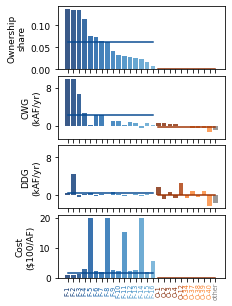

In [11]:
### default
s = -2
samp = str(results.iloc[s,].samp)
hydro = results.iloc[s,].hydro
project = results.iloc[s,].project

results_single = get_results_single(s,[],[],True)
name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')

abs_thres = 0.5
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))
            
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -4, 6.5, [0,8], [], districts_order, districts_anon, results_single)
# plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

In [ ]:
### alt1 - 2nd largest P-CWG
samp = 1827 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')
            
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

In [ ]:
### alt2 - largest P-DDG
samp = 2454 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')
            
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

scenario                   FKC_experiment_capow_50yr_median_235_FKC_CFWB
num_partners                                                           5
initial_recharge                                                 553.486
tot_storage                                                        1.031
recovery                                                        0.100237
total_partner_avg_gain                                           51.0481
min_partner_avg_gain                                             3.38467
total_other_avg_gain                                             6.99148
min_other_avg_gain                                              -3.26958
total_partner_w5yr_gain                                          25.3514
min_partner_w5yr_gain                                            2.51342
total_other_w5yr_gain                                           -24.2629
min_other_w5yr_gain                                             -9.49294
ginicoef                                           

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


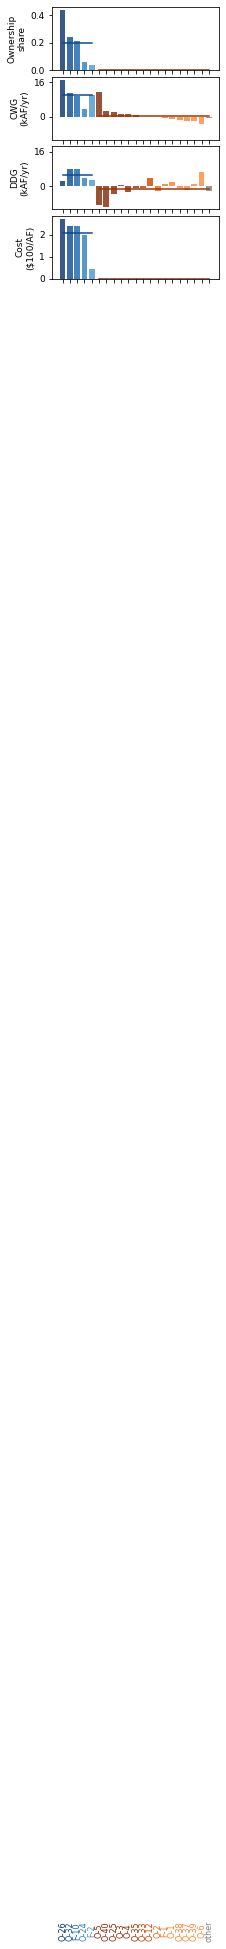

In [13]:
### alt3 - large N-CWG
samp = 235 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')
            
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

In [ ]:
### alt4 - low WP-cost
samp = 1274 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')
            
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

scenario                   FKC_experiment_capow_50yr_median_537_FKC_CFWB
num_partners                                                           8
initial_recharge                                                 404.987
tot_storage                                                      1.02601
recovery                                                        0.227945
total_partner_avg_gain                                           50.5834
min_partner_avg_gain                                             2.36887
total_other_avg_gain                                            -5.25597
min_other_avg_gain                                              -3.58692
total_partner_w5yr_gain                                            15.81
min_partner_w5yr_gain                                          0.0790031
total_other_w5yr_gain                                           -18.3019
min_other_w5yr_gain                                             -9.62575
ginicoef                                           

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


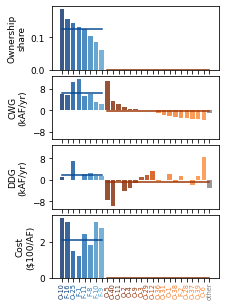

In [130]:
### alt4 - large num partners
samp = 537 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')

abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

       
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

partners = [prices.index[i].split('_')[0] for i in range(prices.shape[0]) if prices[i] > 0]
print(partners)

ylims = make_hist_plot2([s], [''], -0.65, 6.5, [-8,0,8], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

In [ ]:
### alt5 - highest CWG for FKC-only
samp = 981 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')

abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

       
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

print(districts_order[0:results_single.partner.sum()])

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

scenario                   FKC_experiment_capow_50yr_median_2496_FKC_CFWB
num_partners                                                            8
initial_recharge                                                  534.876
tot_storage                                                        1.0893
recovery                                                          0.42881
total_partner_avg_gain                                            57.3683
min_partner_avg_gain                                              4.75264
total_other_avg_gain                                              6.53611
min_other_avg_gain                                               -2.87794
total_partner_w5yr_gain                                           12.3604
min_partner_w5yr_gain                                            -2.30637
total_other_w5yr_gain                                            -20.5941
min_other_w5yr_gain                                              -7.53007
ginicoef                              

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


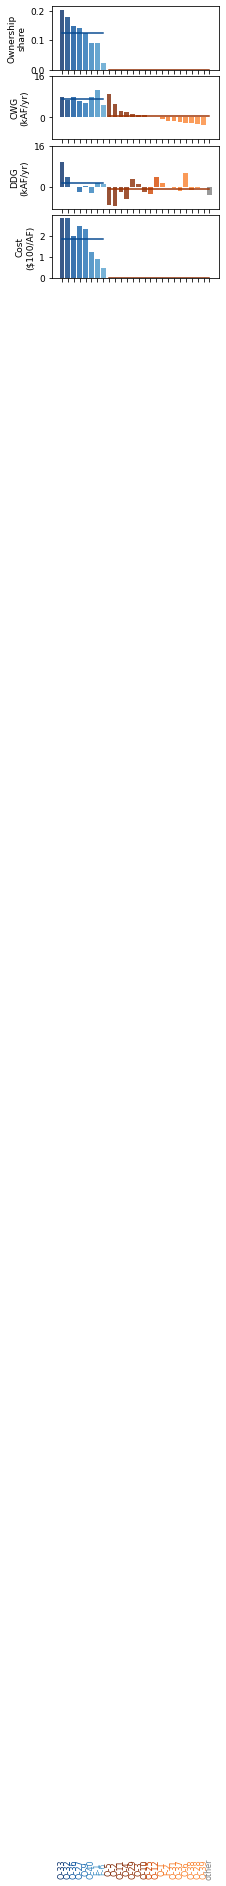

In [12]:
### alt6 - compromise
samp = 2496 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')

abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

       
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

print(districts_order[0:results_single.partner.sum()])

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
# plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

scenario                   FKC_experiment_capow_50yr_median_1553_FKC_CFWB
num_partners                                                            5
initial_recharge                                                  594.927
tot_storage                                                      0.929875
recovery                                                         0.426573
total_partner_avg_gain                                            63.4286
min_partner_avg_gain                                                3.488
total_other_avg_gain                                             -0.30793
min_other_avg_gain                                               -4.03935
total_partner_w5yr_gain                                           13.6693
min_partner_w5yr_gain                                            -7.49264
total_other_w5yr_gain                                            -34.0599
min_other_w5yr_gain                                              -18.2017
ginicoef                              

/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


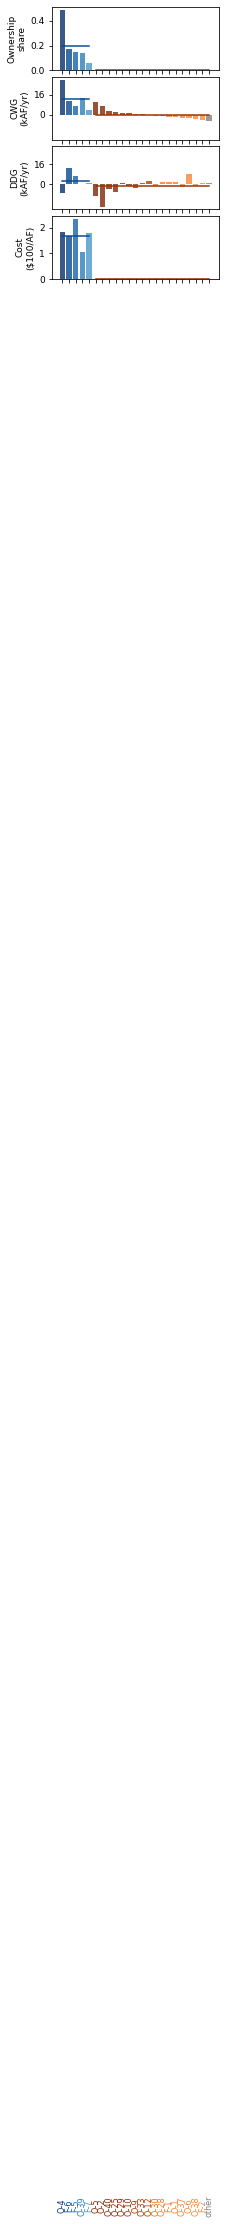

In [14]:
### alt7 - compromise
samp = 1553 
hydro = 'median'
project = 'FKC_CFWB'
try:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
except:
    idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
s = idx
samp = str(samp)

results_single = get_results_single(s,[],[],True)
name = samp + '_' + hydro + '_' + project
results_single.to_csv('figures/results_' + name + '.csv')

abs_thres = 1
num_other = 0
results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                     'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

       
for d in results_single.index[:-1]:
    if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
        results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
        results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
        results_single = results_single.loc[results_single.district != d]
        num_other += 1
anon_dict['other'] = 'other'

# results_single = get_colors(s, results_single, 'share', 'exp_gain')
results_single.color.loc['other'] = '0.5'
districts_order = results_single.district
districts_color = results_single.color
districts_anon = [anon_dict[d] for d in districts_order]
results_single.district_label = districts_anon

print(results.iloc[s,:20])
print(results.iloc[s,]['avg_price_gain_dolAF'])
prices = results.iloc[s,:].loc[avg_price_keys]
print('min price: ', min([v for v in prices if v > 0]))
print('max price: ', max([v for v in prices if v > 0]))

print(districts_order[0:results_single.partner.sum()])

ylims = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
# plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

### 3 panels for 3 diff projects, med+FKC_CFWB

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 1
samps = [1827, 2454, 537]
ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
for samp in samps:
    hydro = 'median'
    project = 'FKC_CFWB'
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp)

    results_single = get_results_single(s,[],[],True)
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon

    ylims_single = make_hist_plot2([s], [''], -75, 8, [0,16], [], districts_order, districts_anon, results_single)
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])

for samp in samps:
    hydro = 'median'
    project = 'FKC_CFWB'
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp)

    results_single = get_results_single(s,[],[],True)
    name = samp + '_' + hydro + '_' + project
    results_single.to_csv('figures/results_' + name + '.csv')
    
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))
      
    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon
    
    ylims_single = make_hist_plot2([s], [''], -75, 8, [0,16], ylims, districts_order, districts_anon, results_single)

    plt.savefig('figures/' + 'hist_' + name + '.png',bbox_inches='tight', dpi=500)

### 3 panels for 1 projects, 3 hydro

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 0.5

ss = [-3,-2,-1]

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
for s in ss:
    samp = str(results.iloc[s,].samp)
    hydro = results.iloc[s,].hydro
    project = results.iloc[s,].project


    results_single = get_results_single(s,[],[],True)
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon

    ylims_single = make_hist_plot2([s], [''], -75, 8, [-10,0,10], [], districts_order, districts_anon, results_single)
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])

for s in ss:
    samp = str(results.iloc[s,].samp)
    hydro = results.iloc[s,].hydro
    project = results.iloc[s,].project

    results_single = get_results_single(s,[],[],True)
    name = samp + '_' + hydro + '_' + project
    results_single.to_csv('figures/results_' + name + '.csv')
    
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))
      
    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon
    
    ylims_single = make_hist_plot2([s], [''], -450, 8, [-10,0,10], ylims, districts_order, districts_anon, results_single)

    plt.savefig('figures/' + 'hist_' + name + '_hydro.png',bbox_inches='tight', dpi=500)

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 0.5
samp0 = 537
project = 'FKC_CFWB'
hydros = ['wet','median','dry']

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
for hydro in hydros:
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single = get_results_single(s,[],[],True)
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon

    ylims_single = make_hist_plot2([s], [''], -75, 8, [-10,0,10], [], districts_order, districts_anon, results_single)
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])

for hydro in hydros:
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single = get_results_single(s,[],[],True)
    name = samp + '_' + hydro + '_' + project
    results_single.to_csv('figures/results_' + name + '.csv')
    
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))
      
    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon
    
    ylims_single = make_hist_plot2([s], [''], -220, 7, [-10,0,10], ylims, districts_order, districts_anon, results_single)

    plt.savefig('figures/' + 'hist_' + name + '_hydro.png',bbox_inches='tight', dpi=500)

### 3 panels for 1 sample, med hydro, 3 project types

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 1
samp0 = 537
projects = ['FKC','CFWB','FKC_CFWB']
hydro = 'median'

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
for project in projects:
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single = get_results_single(s,[],[],True)
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))

    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon

    ylims_single = make_hist_plot2([s], [''], -75, 8, [-10,0,10], [], districts_order, districts_anon, results_single)
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])

for project in projects:
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single = get_results_single(s,[],[],True)
    name = samp + '_' + hydro + '_' + project
    results_single.to_csv('figures/results_' + name + '.csv')
    
    num_other = 0
    results_single = results_single.append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                         'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0}, index=['other']))
      
    for d in results_single.index[:-1]:
        if (results_single.loc[d, 'partner'] == 0) and (abs(results_single.loc[d, 'exp_gain']) < abs_thres) and (abs(results_single.loc[d, 'w5yr_gain']) < abs_thres):
            results_single.loc['other', 'exp_gain'] += results_single.loc[d, 'exp_gain']
            results_single.loc['other', 'w5yr_gain'] += results_single.loc[d, 'w5yr_gain']   
            results_single = results_single.loc[results_single.district != d]
            num_other += 1
    anon_dict['other'] = 'other'

#     results_single = get_colors(s, results_single, 'share', 'exp_gain')
    results_single.color.loc['other'] = '0.5'
    districts_order = results_single.district
    districts_color = results_single.color
    districts_anon = [anon_dict[d] for d in districts_order]
    results_single.district_label = districts_anon
    
    ylims_single = make_hist_plot2([s], [''], -450, 8, [-10,0,10], ylims, districts_order, districts_anon, results_single)

    plt.savefig('figures/' + 'hist_' + name + '_project.png',bbox_inches='tight', dpi=500)

### 3 panels for 1 sample, med hydro, 3 project types - consistent ordering

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 2
samp0 = 537
projects = ['FKC','CFWB','FKC_CFWB']
hydro = 'median'

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
results_single = []
for i,project in enumerate(projects):
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single.append(get_results_single(s,[],[],True))
    ### set order & color based on first dataset
    if i == 0:
        districts_order = results_single[i].district
        results_single[i] = get_colors(s, results_single[i], 'share', 'exp_gain')
        districts_color = results_single[i].color
        districts_anon = [anon_dict[d] for d in districts_order]
    else:
        results_single[i] = results_single[i].loc[districts_order]
        results_single[i]['color'] = districts_color
    results_single[i].district_label = districts_anon
    
    
### find districts that have small changes in all 3 scenarios
other = []
for d in results_single[0].index[:-1]:
    if (results_single[0].loc[d, 'partner'] == 0) and \
        (abs(results_single[0].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[0].loc[d, 'w5yr_gain']) < abs_thres) and \
        (abs(results_single[1].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[1].loc[d, 'w5yr_gain']) < abs_thres) and \
        (abs(results_single[2].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[2].loc[d, 'w5yr_gain']) < abs_thres):

        other.append(d)
          
for i in range(len(results_single)):
    results_single[i] = results_single[i].append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                 'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0, 'color':'0.5'}, index=['other']))
    for d in other:
            results_single[i].loc['other', 'exp_gain'] += results_single[i].loc[d, 'exp_gain']
            results_single[i].loc['other', 'w5yr_gain'] += results_single[i].loc[d, 'w5yr_gain']   
            results_single[i] = results_single[i].loc[results_single[i].district != d]
            num_other += 1
    anon_dict['other'] = 'other'
    districts_color = results_single[i].color

    ylims_single = make_hist_plot2([s], [''], -400, 7, [-10,0,10], [], districts_order, districts_anon, results_single[i])
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])
        
for i,project in enumerate(projects):
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)
    
    ylims_single = make_hist_plot2([s], [''], -400, 7, [-10,0,10], ylims, districts_order, districts_anon, results_single[i])

    plt.savefig('figures/' + 'hist_' + name + '_project.png',bbox_inches='tight', dpi=500)

### 3 panels for 1 sample, 3 hydro, 1 project types - consistent ordering

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 2
samp0 = 537
project = 'FKC_CFWB'
hydros = ['median','wet','dry']

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
results_single = []
for i,hydro in enumerate(hydros):
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)

    results_single.append(get_results_single(s,[],[],True))
    ### set order & color based on first dataset
    if i == 0:
        districts_order = results_single[i].district
        results_single[i] = get_colors(s, results_single[i], 'share', 'exp_gain')
        districts_color = results_single[i].color
        districts_anon = [anon_dict[d] for d in districts_order]
    else:
        results_single[i] = results_single[i].loc[districts_order]
        results_single[i]['color'] = districts_color
    results_single[i].district_label = districts_anon
    
    
### find districts that have small changes in all 3 scenarios
other = []
for d in results_single[0].index[:-1]:
    if (results_single[0].loc[d, 'partner'] == 0) and \
        (abs(results_single[0].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[0].loc[d, 'w5yr_gain']) < abs_thres) and \
        (abs(results_single[1].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[1].loc[d, 'w5yr_gain']) < abs_thres) and \
        (abs(results_single[2].loc[d, 'exp_gain']) < abs_thres) and (abs(results_single[2].loc[d, 'w5yr_gain']) < abs_thres):

        other.append(d)
          
for i in range(len(results_single)):
    results_single[i] = results_single[i].append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                 'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0, 'color':'0.5'}, index=['other']))
    for d in other:
            results_single[i].loc['other', 'exp_gain'] += results_single[i].loc[d, 'exp_gain']
            results_single[i].loc['other', 'w5yr_gain'] += results_single[i].loc[d, 'w5yr_gain']   
            results_single[i] = results_single[i].loc[results_single[i].district != d]
            num_other += 1
    anon_dict['other'] = 'other'
    districts_color = results_single[i].color

    ylims_single = make_hist_plot2([s], [''], -450, 7, [-10,0,10], [], districts_order, districts_anon, results_single[i])
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])
        
for i,hydro in enumerate(hydros):
    try:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
    except:
        idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
    s = idx
    samp = str(samp0)
    
    ylims_single = make_hist_plot2([s], [''], -200, 7, [-10,0,10], ylims, districts_order, districts_anon, results_single[i])

    plt.savefig('figures/' + 'hist_' + name + '_hydro.png',bbox_inches='tight', dpi=500)

### 9 panels - 3x3 hydro & project type

In [ ]:
### alt1 - 2nd largest P-CWG
abs_thres = 1
samp0 = 537
projects = ['FKC_CFWB', 'FKC','CFWB']
hydros = ['median','wet','dry']

ylims = [[np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf], [np.inf, -np.inf]]
results_single = []
i = 0
for j,hydro in enumerate(hydros):
    for k, project in enumerate(projects):
        try:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
        except:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
        s = idx
        samp = str(samp0)

        results_single.append(get_results_single(s,[],[],True))
        ### set order & color based on first dataset
        if i == 0:
            districts_order = results_single[i].district
            results_single[i] = get_colors(s, results_single[i], 'share', 'exp_gain')
            districts_color = results_single[i].color
            districts_anon = [anon_dict[d] for d in districts_order]
        else:
            results_single[i] = results_single[i].loc[districts_order]
            results_single[i]['color'] = districts_color
        results_single[i].district_label = districts_anon

        i += 1
    
### find districts that have small changes in all 3 scenarios
other = []
for d in results_single[0].index[:-1]:
    keep_d = False
    for i in range(len(results_single)):
        should_keep = (results_single[i].loc[d, 'partner'] == 1) or \
                       ((abs(results_single[i].loc[d, 'exp_gain']) > abs_thres) or \
                        (abs(results_single[i].loc[d, 'w5yr_gain']) > abs_thres))
        keep_d = keep_d or should_keep
             
    if not keep_d:
        other.append(d)
          

for i in range(len(results_single)):
    results_single[i] = results_single[i].append(pd.DataFrame({'district_label': 'other', 'district': 'other', 'share': 0 , 
                                                 'exp_gain': 0, 'w5yr_gain': 0, 'avg_price': 0, 'partner': 0, 'color':'0.5'}, index=['other']))
    for d in other:
            results_single[i].loc['other', 'exp_gain'] += results_single[i].loc[d, 'exp_gain']
            results_single[i].loc['other', 'w5yr_gain'] += results_single[i].loc[d, 'w5yr_gain']   
            results_single[i] = results_single[i].loc[results_single[i].district != d]
            num_other += 1
    anon_dict['other'] = 'other'
    districts_color = results_single[i].color

    ylims_single = make_hist_plot2([s], [''], -450, 7, [-10,0,10], [], districts_order, districts_anon, results_single[i])
    for row in range(4):
        ylims[row][0] = min(ylims[row][0], ylims_single[row][0])
        ylims[row][1] = max(ylims[row][1], ylims_single[row][1])
        
i = 0
for j,hydro in enumerate(hydros):
    for k, project in enumerate(projects):
        try:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
        except:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
        s = idx
        samp = str(samp0)
    
        ylims_single = make_hist_plot2([s], [''], -200, 7, [-10,0,10], ylims, districts_order, districts_anon, results_single[i])

        plt.savefig('figures/' + 'hist_' + name + '_9panel.png',bbox_inches='tight', dpi=500)
        
        i += 1

### 9 panels - 3x3 hydro & project type - cost only

In [144]:
def make_hist_plot_9panelcost(ylab_shift=-300, district_label_fontsize=9, districts_order=[], districts_anon=[], results_single=[], ss=[], samp=0):
    fig, axs = plt.subplots(3,3, figsize=(3.5,3.5), sharex=True, gridspec_kw={'hspace':0.1, 'wspace':0.1})
    
    N = results_single[0].shape[0]
    npartners = sum(results_single[0].partner)

    def plot_averages(key, x, y, ax, datanum):
        partner_dict = {'avg_price': min(results.iloc[ss[datanum],:].loc['avg_price_gain_dolAF'], 2000)}
        other_dict = {'avg_price': min(results.iloc[ss[datanum],:].loc['avg_price_gain_dolAF'], 2000)} 

        ax.plot(x[:npartners], [partner_dict[key] for _ in x[:npartners]], c=cm.get_cmap('Blues')(0.9))

        if key in ['exp_gain', 'w5yr_gain']:
            ax.plot(x[npartners:], [other_dict[key] for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.9))
        else:
            ax.plot(x[npartners:], [0 for _ in x[npartners:]], c=cm.get_cmap('Oranges')(0.95))


    def plot_single_hist(key, ax, datanum=0, use_xlab=False, use_ylab=False, ax_sharey=None):
        label_dict = {'share': 'Ownership\nshare', 'exp_gain': 'CWG\n(kAF/yr)', 
                      'w5yr_gain': 'DDG\n(kAF/yr)', 'avg_price': 'Cost\n($/AF)'}
        label = label_dict[key]
        height = results_single[datanum][key] 

        colors = districts_color
        bars = ax.bar(results_single[datanum]['district'], height)
        for r, c, bar in zip(height, colors, bars):
            bar.set_facecolor(c)
            bar.set_alpha(0.8)
        plot_averages(key, results_single[datanum]['district'], height, ax, datanum)
        ax.set_xticklabels(['' for _ in results_single[datanum]['district']])

        if not use_ylab:
            ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
        else:
            ax.set_ylabel(label)

    def plot_district_labels(labels, colors, ax, label_offset, fontsize):
        for i in range(N):
            ax.annotate(results_single[0]['district_label'].iloc[i], (i, label_offset),ha='center', va='center', ma='center', 
                        color=colors[i], rotation= 90, annotation_clip=False, fontsize=fontsize)

    i = 0
    for col in range(3):
        for row in range(3):
            ax = axs[row,col]
            ## hist of costs
            plot_single_hist('avg_price', axs[row,col], i)
            ax.set_ylim([0,21])
            ## labels
            if col == 0:
                ax.set_ylabel('Cost\n($100/AF)')
                ax.set_yticklabels([0,10,20])
            if row == 0:
                ax.annotate(['Canal','Bank','Both'][col], (0.5, 1.1),ha='center', va='center', ma='center', 
                            xycoords = 'axes fraction', annotation_clip=False)
            if col == 2:
                ax.annotate(['Wet','Avg.','Dry'][row], (1.1, 0.5),ha='center', va='center', ma='center', rotation=270,
                            xycoords = 'axes fraction', annotation_clip=False)
            ax.annotate(labels[i],(0.9, 0.9),ha='center', va='center', ma='center', 
                            xycoords = 'axes fraction', annotation_clip=False)
            i += 1
            
        plot_district_labels(results_single[0]['district'], districts_color, axs[2,col], ylab_shift, district_label_fontsize)
    
    
    fig.tight_layout()
    plt.savefig('figures/' + 'hist_price_' + samp + '_9panel.png',bbox_inches='tight', dpi=500)



/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/andrew/projects/CALFEWS/.venv_calfews2/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter sho

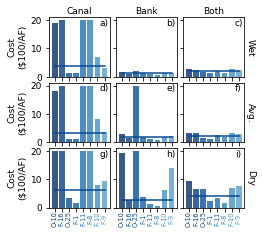

In [147]:
samp0 = 537
projects = ['FKC','CFWB','FKC_CFWB']
hydros = ['wet','median','dry']
labels = ['a)','d)','g)','b)','e)','h)','c)','f)','i)']

results_single = []
ss = []
i = 0
for j,project in enumerate(projects):
    for k, hydro in enumerate(hydros):
        try:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == samp0, results.project == project), results.hydro == hydro)].index[0]
        except:
            idx = results.loc[np.logical_and(np.logical_and(results.samp == str(samp0), results.project == project), results.hydro == hydro)].index[0]
        s = idx
        ss.append(s)
        samp = str(samp0)

        results_single.append(get_results_single(s,[],[],True))
        results_single[i] = results_single[i].iloc[:results_single[i].partner.sum()]
        ### set order & color based on first dataset
        if i == 0:
            districts_order = results_single[i].district
            results_single[i] = get_colors(s, results_single[i], 'share', 'exp_gain')
            districts_color = results_single[i].color
            districts_anon = [anon_dict[d] for d in districts_order]
        else:
            results_single[i] = results_single[i].loc[districts_order]
            results_single[i]['color'] = districts_color
        results_single[i].district_label = districts_anon

        i += 1
    


make_hist_plot_9panelcost(-4, 6.5, districts_order, districts_anon, results_single, ss, samp)



### start over, new histograms w/ partners only

In [9]:
pal_zissou1_5 = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]
cdict_hydro = {'wet': pal_zissou1_5[0], 'median': pal_zissou1_5[2], 'dry': pal_zissou1_5[4]}

In [10]:
idx = 27283 #14983
sol = results.iloc[idx-1:idx+2,]
soldis = [d for d in districts if sol.iloc[0,].loc[d + '_share'] > 0]
solshares = [-sol.iloc[0,].loc[d + '_share'] for d in soldis]
sort = np.argsort(solshares)
soldis = [soldis[s] for s in sort]
solshares = [-solshares[s] for s in sort]


In [11]:
def get_district_hists(idx):
    # idx = 27283 #14983
    sol = results.iloc[idx-1:idx+2,]
    soldis = [d for d in districts if sol.iloc[0,].loc[d + '_share'] > 0]
    solshares = [-sol.iloc[0,].loc[d + '_share'] for d in soldis]
    sort = np.argsort(solshares)
    soldis = [soldis[s] for s in sort]
    solshares = [-solshares[s] for s in sort]

    df = pd.read_csv('figures/results_boxplot_combined.csv')
    sharecolors = [df['color'].loc[df['district'] == d].iloc[0] for d in soldis]
    sharex = [x + 0.125 for x in range(len(soldis))]
    
    solgaindry = [sol.iloc[0,].loc[d + '_exp_gain'] for d in soldis]
    solgainmed = [sol.iloc[1,].loc[d + '_exp_gain'] for d in soldis]
    solgainwet = [sol.iloc[2,].loc[d + '_exp_gain'] for d in soldis]
    solcostdry = [min(sol.iloc[0,].loc[d + '_avg_price']/100, 20) for d in soldis]
    solcostmed = [min(sol.iloc[1,].loc[d + '_avg_price']/100, 20) for d in soldis]
    solcostwet = [min(sol.iloc[2,].loc[d + '_avg_price']/100, 20) for d in soldis]

    solgaincomb = []
    solcostcomb = []
    costx = []
    costcolors = []
    for i in range(len(soldis)):
        solgaincomb.append(solgaindry[i])
        solgaincomb.append(solgainmed[i])    
        solgaincomb.append(solgainwet[i])    
        solcostcomb.append(solcostdry[i])
        solcostcomb.append(solcostmed[i])    
        solcostcomb.append(solcostwet[i])   
        costx.append(i*4+0.5)
        costx.append(i*4+1.5)
        costx.append(i*4+2.5)
        costcolors.append(cdict_hydro['dry'])
        costcolors.append(cdict_hydro['median'])    
        costcolors.append(cdict_hydro['wet'])    
        
    soldict = {'solnum':len(soldis), 'soldis':soldis, 'solshares':solshares, 'sharex':sharex, 'sharecolors':sharecolors, 
               'solgaindry':solgaindry, 'solgainmed':solgainmed, 'solgainwet':solgainwet, 'solgaincomb':solgaincomb,
               'solcostdry':solcostdry, 'solcostmed':solcostmed, 'solcostwet':solcostwet, 'solcostcomb':solcostcomb,
               'costx':costx, 'costcolors':costcolors, 
               'soltotgaindry': sol.iloc[0,].loc['total_partner_avg_gain'],
               'soltotgainmed': sol.iloc[1,].loc['total_partner_avg_gain'],
               'soltotgainwet': sol.iloc[2,].loc['total_partner_avg_gain'],
               'soltotcostdry': sol.iloc[0,].loc['avg_price_gain_dolAF']/100,
               'soltotcostmed': sol.iloc[1,].loc['avg_price_gain_dolAF']/100,
               'soltotcostwet': sol.iloc[2,].loc['avg_price_gain_dolAF']/100}
    
    print(idx, ': ', soldis)
    return(soldict)

27283 :  ['ARV', 'LWT', 'DLE', 'SSJ', 'OFK', 'TUL', 'SFW', 'COF', 'LND', 'SAU', 'TBA', 'LDS', 'PRT', 'FRS', 'EXE', 'TPD']
8071 :  ['ID4', 'LWT', 'PIX']
14983 :  ['LHL', 'KRT', 'OTL', 'KND', 'SOC', 'NKN', 'ARV', 'TUL']


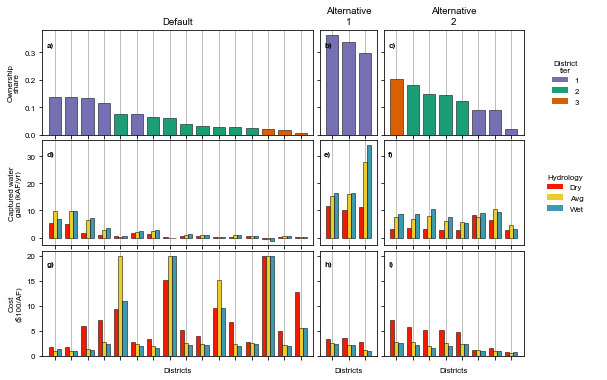

In [12]:
idxs = [27283, 8071, 14983]
solns = [get_district_hists(i) for i in idxs]

xratios = [(solns[i]['solnum']+0.5) / (sum([solns[j]['solnum'] for j in range(len(solns))])+1.5) for i in range(len(solns))]
xratios.append(0.15)
fig, axs = plt.subplots(3, len(solns)+1, figsize=(10,6), sharex=False, sharey='row', 
                        gridspec_kw={'hspace':0.05, 'wspace':0.05, 'width_ratios':xratios})
labels = [['a)','b)','c)'], ['d)','e)','f)'], ['g)','h)','i)']]
labelpos = [[[0,0.32],[0,0.32],[0,0.32]], 
            [[0,30],[0,30],[0,30]], 
            [[0,18],[0,18],[0,18]]]
xlims = [[[-0.25, 16.25], [-0.25,3.25], [-0.25,8.25]],
         [[-1, 65], [-1,13], [-1,33]],
         [[-1, 65], [-1,13], [-1,33]]]
titles = ['Default','Alternative\n1','Alternative\n2']
for col, soln in enumerate(solns):
    row = 0
    ax = axs[row, col]
    ax.bar(soln['sharex'], soln['solshares'], color=soln['sharecolors'], zorder=2, width=0.75, align='edge', edgecolor='k', lw=0.5)
    ax.set_xticks([i+0.5 for i in range(soln['solnum'])])
    ax.set_xticklabels([])
    for x in [i+0.5 for i in range(soln['solnum'])]:
        ax.axvline(x, color='0.5', lw=0.5, zorder=1)
    ax.annotate(labels[row][col], xy=labelpos[row][col], weight='bold')
    if col==0:
        ax.set_ylabel('Ownership\nshare')
    ax.set_title(titles[col])
    ax.set_xlim(xlims[row][col])
    
    row = 1
    ax = axs[row, col]
    ax.bar(soln['costx'], soln['solgaincomb'], color=soln['costcolors'], zorder=2, width=1, align='edge', edgecolor='k', lw=0.5)
    ax.set_xticks([4*i+2 for i in range(soln['solnum'])])
    ax.set_xticklabels([])
    for x in [4*i+2 for i in range(soln['solnum'])]:
        ax.axvline(x, color='0.5', lw=0.5, zorder=1)
    ax.annotate(labels[row][col], xy=labelpos[row][col], weight='bold')
    if col==0:
        ax.set_ylabel('Captured water\ngain (kAF/yr)')
    ax.set_xlim(xlims[row][col])
    
    row = 2
    ax = axs[row, col]
    ax.bar(soln['costx'], soln['solcostcomb'], color=soln['costcolors'], zorder=2, width=1, align='edge', edgecolor='k', lw=0.5)
    ax.set_xticks([4*i+2 for i in range(soln['solnum'])])
    ax.set_xticklabels([])
    for x in [4*i+2 for i in range(soln['solnum'])]:
        ax.axvline(x, color='0.5', lw=0.5, zorder=1)
    ax.annotate(labels[row][col], xy=labelpos[row][col], weight='bold')
    if col==0:
        ax.set_ylabel('Cost\n($100/AF)')    
    ax.set_xlabel('Districts')
    ax.set_xlim(xlims[row][col])
    
    
# ## add legends
leg_hydro = [Patch(facecolor=cdict_hydro['dry'], label='Dry'),
             Patch(facecolor=cdict_hydro['median'], label='Avg'),
             Patch(facecolor=cdict_hydro['wet'], label='Wet')]
leg1 = axs[1, len(idxs)].legend(handles=leg_hydro, loc='center', bbox_to_anchor=(0.5,0.5), title='Hydrology', frameon=False)
leg1.get_title().set_ma('center')

leg_tier = [Patch(facecolor=solns[0]['sharecolors'][0], label='1'),
             Patch(facecolor=solns[0]['sharecolors'][4], label='2'),
             Patch(facecolor=solns[0]['sharecolors'][-1], label='3')]
leg1 = axs[0, len(idxs)].legend(handles=leg_tier, loc='center', bbox_to_anchor=(0.5,0.5), title='District\ntier', frameon=False)
leg1.get_title().set_ma('center')

for ax in axs[:,-1]:
    ax.set_xticks([])
    ax.tick_params(left=False)
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

figname = 'alternatives_' + str(idxs)
# plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

27283 :  ['ARV', 'LWT', 'DLE', 'SSJ', 'OFK', 'TUL', 'SFW', 'COF', 'LND', 'SAU', 'TBA', 'LDS', 'PRT', 'FRS', 'EXE', 'TPD']
14983 :  ['LHL', 'KRT', 'OTL', 'KND', 'SOC', 'NKN', 'ARV', 'TUL']
8071 :  ['ID4', 'LWT', 'PIX']
0 0 0 2.293605094287675
0 1 0 7.857075277166909
0 2 0 22.372819921758268
0 0 1 1.853376357222673
0 1 1 1.7003800069411172
0 2 1 1.5924100476737153
1 0 0 2.347457390991155
1 1 0 7.17103712709975
1 2 0 19.806120023822444
1 0 1 1.8108586212776432
1 1 1 1.8630518121064679
1 2 1 1.798772459994758
2 0 0 1.1723196913164033
2 1 0 4.091171111554456
2 2 0 11.097928660290632
2 0 1 3.626070163322844
2 1 1 3.2655719719456475
2 2 1 3.2102119529456004


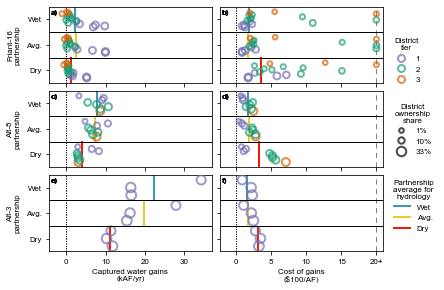

In [14]:
### try again but with boxplot (or similar) for district outcomes
idxs = [27283, 14983, 8071]
solns = [get_district_hists(i) for i in idxs]

fig, axs = plt.subplots(3,2, figsize=(6,4.5), sharex='col', sharey=True, 
                        gridspec_kw={'hspace':0.1, 'wspace':0.05})

rowargs = [['solgainwet', 'solcostwet'], ['solgainmed', 'solcostmed'], ['solgaindry', 'solcostdry']]
rowavgargs = [['soltotgainwet', 'soltotcostwet'], ['soltotgainmed', 'soltotcostmed'], ['soltotgaindry', 'soltotcostdry']]
hydronames = ['Wet','Avg.','Dry']
cols = ['Captured water gains\n(kAF/yr)', 'Cost of gains\n($100/AF)']
solnames = ['Friant-16\npartnership','Alt-8\npartnership','Alt-3\npartnership']
hydrocols = [cdict_hydro['wet'], cdict_hydro['median'], cdict_hydro['dry']]
labels = [['a)','b)'], ['c)','d)'],['e)','f)']]

for s in range(3):
    for col in range(2):
        for row, sol in enumerate(solns):
            ax = axs[row, col]
            avgmet = sol[rowavgargs[s][col]]
            if col==0:
                avgmet /= sol['solnum']
            print(s, row, col, avgmet)
            ax.plot([avgmet, avgmet], [2-s-0.47, 2-s+0.47], c=hydrocols[s], zorder=2, lw=2)
            for i in range(sol['solnum']):
                y = 1.7 - s + (i)/(sol['solnum']-1)*0.6
                ax.scatter(sol[rowargs[s][col]][i], y, color='none', edgecolor=sol['sharecolors'][i],
                           lw=2, alpha=0.7, s=20 + 210*sol['solshares'][i], zorder=3)
            ax.set_ylim([-0.5,2.5])
            ax.set_yticks([2,1,0])
            ax.set_yticklabels(hydronames)
            if col==0:
                ax.set_ylabel(solnames[row], labelpad=5)   
            if row==2:
                ax.set_xlabel(cols[col])
            ax.axhline(1.5, c='k', zorder=5, lw=ax.spines['top'].get_linewidth())
            ax.axhline(0.5, c='k', zorder=5, lw=ax.spines['top'].get_linewidth())     
            ax.axvline(0, c='k', zorder=1, lw=ax.spines['top'].get_linewidth(), ls='--', dashes=(1,2))
            if col==1:
                ax.axvline(20, c='0.5', zorder=1, lw=ax.spines['top'].get_linewidth(), ls='--', dashes=(6,6))
                if row==2:
                    ax.set_xticks([0,5,10,15,20])
                    ax.set_xticklabels(['0','5','10','15','20+'])
            if col==0:
                ax.annotate(labels[row][col], (-4,2.2), weight='bold')
                ax.set_xlim([-4.5,37])
            else:
                ax.annotate(labels[row][col], (-2,2.2), weight='bold')
                ax.set_xlim([-2.2,21])
            
### add legend
ax = axs[0,1]
leg_hands = [Line2D([0],[0], markeredgecolor=solns[0]['sharecolors'][0], color='none', label='1', marker='o', markersize=7, lw=0, markeredgewidth=2, alpha=0.7),
             Line2D([0],[0], markeredgecolor=solns[0]['sharecolors'][4], color='none', label='2', marker='o', markersize=7, lw=0, markeredgewidth=2, alpha=0.7),
             Line2D([0],[0], markeredgecolor=solns[0]['sharecolors'][-1], color='none', label='3', marker='o', markersize=7, lw=0, markeredgewidth=2, alpha=0.7)]
leg1 = ax.legend(handles=leg_hands, loc='center left', title='District\ntier', bbox_to_anchor=(1.015,0.3), frameon=False)
plt.setp(leg1.get_title(), multialignment='center')

ax = axs[1,1]
leg_hands = [Line2D([0],[0], markeredgecolor='k', color='none', label='1%', marker='o', markersize=math.sqrt(20 + 210*0.01), lw=0, markeredgewidth=2, alpha=0.7),
             Line2D([0],[0], markeredgecolor='k', color='none', label='10%', marker='o', markersize=math.sqrt(20 + 210*0.1), lw=0, markeredgewidth=2, alpha=0.7),
             Line2D([0],[0], markeredgecolor='k', color='none', label='33%', marker='o', markersize=math.sqrt(20 + 210*0.33), lw=0, markeredgewidth=2, alpha=0.7)]
leg1 = ax.legend(handles=leg_hands, loc='center left', title='District\nownership\nshare', bbox_to_anchor=(1.015,0.5), frameon=False)
plt.setp(leg1.get_title(), multialignment='center')

ax = axs[2,1]
leg_hands = [Line2D([0],[0], color=cdict_hydro['wet'], label='Wet', lw=2),
             Line2D([0],[0], color=cdict_hydro['median'], label='Avg.', lw=2),
             Line2D([0],[0], color=cdict_hydro['dry'], label='Dry', lw=2)]
leg1 = ax.legend(handles=leg_hands, loc='center left', title='Partnership\naverage for\nhydrology', bbox_to_anchor=(1.015,0.6), frameon=False)
plt.setp(leg1.get_title(), multialignment='center')

figname = 'scatter_alternatives_' + str(idxs)
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)

In [22]:
for i,varlist in enumerate(rowavgargs):
    for soln in solns:
        print(varlist[1], soln['solnum'], soln[varlist[1]])

soltotcostwet 16 1.853376357222673
soltotcostwet 8 1.7003800069411172
soltotcostwet 3 1.5924100476737153
soltotcostmed 16 1.8108586212776432
soltotcostmed 8 1.8630518121064679
soltotcostmed 3 1.798772459994758
soltotcostdry 16 3.626070163322844
soltotcostdry 8 3.2655719719456475
soltotcostdry 3 3.2102119529456004


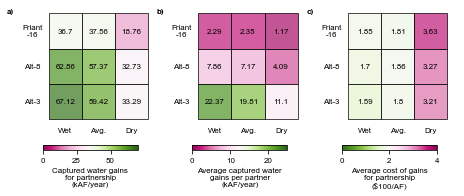

In [81]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

### plot partnership averages in tile plot
fig,axs = plt.subplots(1,3,figsize=(7.8,3), gridspec_kw={'wspace':0.1})

### params for CWG & Cost plots
varindexes = [0,0,1]
cmapnames = ['PiYG', 'PiYG', 'PiYG_r']
cmapmaxs = [70,25,4]
cmapmins = [0,0,0]
cmaplabels = ['Captured water gains\nfor partnership\n(kAF/year)',
              'Average captured water\ngains per partner\n(kAF/year)',
              'Average cost of gains\nfor partnership\n($100/AF)']
labels = ['a)','b)','c)']
for i in range(3):
    ax = axs[i]

    ### now plot patches with percentages
    cmap = cm.get_cmap(cmapnames[i])
    rownames = ['Friant\n-16', 'Alt-8', 'Alt-3']
    colnames = ['Wet', 'Avg.', 'Dry',]

    def get_color(cmap, value, maxval, minval):
        valnorm = (value - minval) / (maxval - minval)
        return cmap(valnorm)


    for r,varlist in enumerate(rowavgargs):
        for c,soln in enumerate(solns):
            xy = np.zeros((5,2))
            xy[0,] = (r, 2-c)
            xy[1,] = (r, 2-c+1)
            xy[2,] = (r+1, 2-c+1)
            xy[3,] = (r+1, 2-c)
            xy[4,] = (r, 2-c)

            path = mpath.Path(xy)
            value = soln[varlist[varindexes[i]]]
            if i == 1:
                value /= soln['solnum']
            color = get_color(cmap, value, cmapmaxs[i], cmapmins[i])
            patch = mpatches.PathPatch(path, facecolor=color, edgecolor='k', alpha=0.7)
            ax.add_patch(patch)
            ax.annotate(str(round(value,2)), (xy[:-1,0].mean(), xy[:-1,1].mean()), va='center', ha='center')#, fontsize=10)

            if r == 0:
                ax.annotate(colnames[c], (c+0.5, -0.3), va='center', ha='center', ma='center', zorder=2)

        ax.annotate(rownames[r], (-0.5, 2-r+0.5), va='center', ha='center', ma='center', zorder=2)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['top','right','left','bottom']:
        ax.spines[spine].set_visible(False)


    ax.set_xlim([-0.8, 3.3])
    ax.set_ylim([-0.5, 3.2])

    cb = plt.colorbar(mappable = cm.ScalarMappable(cmap = cmap, norm = Normalize(vmin=cmapmins[i], vmax=cmapmaxs[i])), 
                         ax=ax, shrink=0.7, label=cmaplabels[i], orientation='horizontal', pad=0.05)

    ax.annotate(labels[i], (-1.25, 3), weight='bold', annotation_clip=False)
figname = 'tile_alternatives_' + str(idxs)
plt.savefig('figures/' + figname + '.png', bbox_inches='tight', dpi=300)